<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_Trajectory_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/NIH/Data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
notes_name = "NOTES_NURSISNG_Traj_for_log_reg.csv"
df_notes = pd.read_csv(file_path+notes_name)
df_notes.iloc[0]

ROW_ID_x                                                              799
SUBJECT_ID                                                            847
GENDER                                                                  F
DOB                                                   2109-04-08 00:00:00
DOD                                                                   NaN
DOD_HOSP                                                              NaN
DOD_SSN                                                               NaN
EXPIRE_FLAG                                                             0
CGID                                                                17087
emb_distance                     [0.8922914266586304, 0.7072850465774536]
attitudes               ['Overall Neutral Note', 'Overall Neutral Note...
attitudes_char                                                 [0, 0, -1]
Sentiment_Change                                                   [0, 1]
ROW_ID_y                              

pre-processing

In [ ]:
import ast 
 
y_label = []
x_label = []
feature_names = ['GENDER', 'INSURANCE','RELIGION','AGE','HADM_ID','ETHNICITY']
for idx, row in df_notes.iterrows():
  y_label.extend(ast.literal_eval(row['attitudes']))
  for _ in range(len(ast.literal_eval(row['attitudes']))):
    x_label.append(row[feature_names].tolist())

In [ ]:
df = pd.DataFrame(x_label,columns=feature_names)

# label
df['label'] =  [0 if item=='Overall Neutral Note' else 1 for item in y_label]

# age as number
df['AGE'] = df['AGE'].apply(lambda x: float(x.split()[0]))
df = df[df['AGE']<2]

# hadm as string 
df['HADM_ID'] = df['HADM_ID'].apply(lambda x : str(x))


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 244
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GENDER     239 non-null    object 
 1   INSURANCE  239 non-null    object 
 2   RELIGION   234 non-null    object 
 3   AGE        239 non-null    float64
 4   HADM_ID    239 non-null    object 
 5   ETHNICITY  239 non-null    object 
 6   label      239 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 14.9+ KB


In [ ]:
 df_data = pd.get_dummies(df)
 df_data.head()

,AGE,label,GENDER_F,GENDER_M,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Private,INSURANCE_Self Pay,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,...,HADM_ID_192996,HADM_ID_195123,HADM_ID_199454,HADM_ID_199918,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE
0,0.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.2,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

y = df_data['label'].values
X = df_data.drop('label',axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.metrics import classification_report


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

target_names = ['Neutral', 'Attitude']

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: ', name)
    print(classification_report(y_test, y_pred, target_names=target_names))

Classifier:  Logistic
              precision    recall  f1-score   support

     Neutral       0.72      0.97      0.83        35
    Attitude       0.00      0.00      0.00        13

    accuracy                           0.71        48
   macro avg       0.36      0.49      0.41        48
weighted avg       0.53      0.71      0.60        48

Classifier:  Naive Bayes
              precision    recall  f1-score   support

     Neutral       0.25      0.11      0.16        35
    Attitude       0.03      0.08      0.04        13

    accuracy                           0.10        48
   macro avg       0.14      0.10      0.10        48
weighted avg       0.19      0.10      0.13        48

Classifier:  SVC
              precision    recall  f1-score   support

     Neutral       0.71      0.91      0.80        35
    Attitude       0.00      0.00      0.00        13

    accuracy                           0.67        48
   macro avg       0.36      0.46      0.40        48
weighted a

In [ ]:
np.std(X_train,0)

array([0.14375899, 0.46822795, 0.46822795, 0.27704202, 0.36872915,
       0.43376576, 0.07216779, 0.38686813, 0.07216779, 0.15966441,
       0.30618202, 0.39520994, 0.12433866, 0.31282449, 0.47554718,
       0.07216779, 0.15966441, 0.10179174, 0.23296959, 0.10179174,
       0.07216779, 0.18789904, 0.18789904, 0.12433866, 0.07216779,
       0.12433866, 0.10179174, 0.10179174, 0.07216779, 0.12433866,
       0.10179174, 0.2847513 , 0.07216779, 0.10179174, 0.12433866,
       0.07216779, 0.12433866, 0.17443279, 0.10179174, 0.07216779,
       0.10179174, 0.10179174, 0.26901011, 0.07216779, 0.12433866,
       0.10179174, 0.26062573, 0.12433866, 0.07216779, 0.10179174,
       0.12433866, 0.10179174, 0.12433866, 0.07216779, 0.10179174,
       0.26901011, 0.15966441, 0.10179174, 0.10179174, 0.10179174,
       0.10179174, 0.12433866, 0.12433866, 0.12433866, 0.14319156,
       0.15966441, 0.10179174, 0.10179174, 0.34292195, 0.23296959,
       0.32545069, 0.47201791])

<Axes: xlabel='feature'>

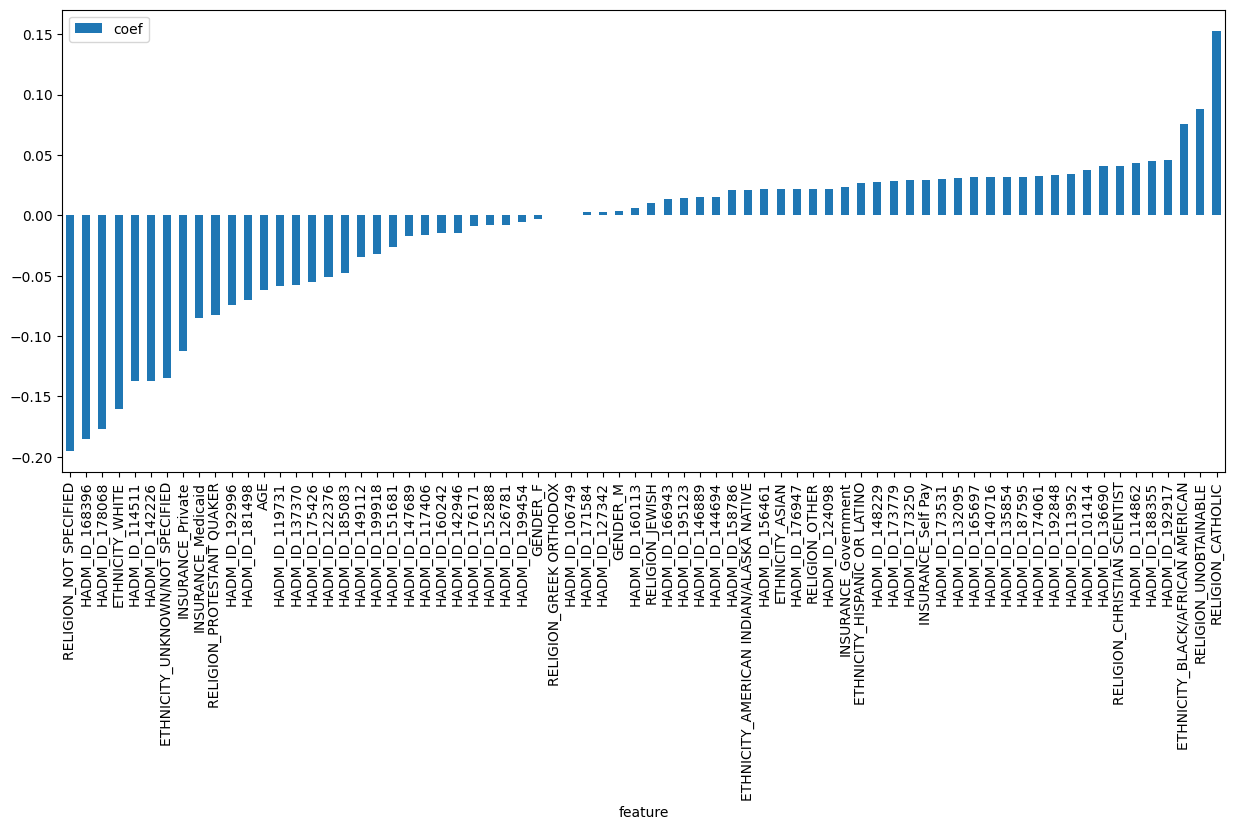

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15, 6]

features = df_data.drop('label',axis=1).columns

clf = lr.fit(X_train, y_train)
# get importance
df_results = pd.DataFrame(list(zip(features,clf.coef_[0]*np.std(X_train,0))), columns = ['feature','coef'])
df_results.sort_values(by='coef').plot.bar(x='feature', y='coef')

In [ ]:
import statsmodels.api as sm

# building the model and fitting the data
log_reg = sm.Logit(y_train, X_train).fit()

# printing the summary table
print(log_reg.summary())

         Current function value: 0.400594
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  191
Model:                          Logit   Df Residuals:                      140
Method:                           MLE   Df Model:                           50
Date:                Tue, 09 May 2023   Pseudo R-squ.:                  0.2194
Time:                        19:40:58   Log-Likelihood:                -76.513
converged:                      False   LL-Null:                       -98.020
Covariance Type:            nonrobust   LLR p-value:                    0.7475
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -11.4891        nan        nan        nan         nan         nan
x2             3.4724        nan        nan        nan         na

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
